In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install scikit-learn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Libraries
!pip install tensorflow numpy matplotlib pillow scikit-learn
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Colab Directory Path
COLAB_ROOT = '/content/drive/MyDrive'
BASE_DIR = 'Tooth_Instance_Analysis_Data'
XRAY_DIR = os.path.join(COLAB_ROOT, BASE_DIR, 'image')
MASK_DIR = os.path.join(COLAB_ROOT, BASE_DIR, 'masks')

image_filenames = sorted(os.listdir(XRAY_DIR))
mask_filenames = sorted(os.listdir(MASK_DIR))

print(f"Total X-ray Images found:{len(image_filenames)}")
print(f"Total Mask Images found:{len(mask_filenames)}")


Total X-ray Images found:598
Total Mask Images found:598


Data Properties
X-ray Array shape: (1024, 2041), Data Type: uint8
Mask Array shape: (1024, 2041, 3), Data Type: uint8
Unique pixel values in mask: [  0  32  42  71  99 128 165 215 218 224 255]


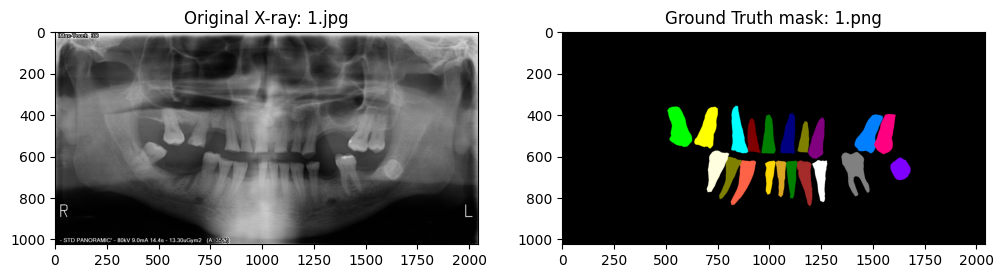

In [ ]:
# Data Verification and Visualisation

# Select First Pair

sample_index = 0
sample_image_name = image_filenames[sample_index]
sample_mask_name = mask_filenames[sample_index]

#Create the full file path

sample_image_path = os.path.join(XRAY_DIR, sample_image_name)
sample_mask_path = os.path.join(MASK_DIR, sample_mask_name)

# Load the Image and Mask using PIL

image = Image.open(sample_image_path)
mask = Image.open(sample_mask_path)

# Convert to numpy array
image_array = np.array(image)
mask_array = np.array(mask)

# Display
print(f"Data Properties")
print(f"X-ray Array shape: {image_array.shape}, Data Type: {image_array.dtype}")
print(f"Mask Array shape: {mask_array.shape}, Data Type: {mask_array.dtype}")

# Unique color check
print(f"Unique pixel values in mask: {np.unique(mask_array)}")

# Plotting figure
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title(f'Original X-ray: {sample_image_name}')

plt.subplot(1, 2, 2)
plt.imshow(mask_array)
plt.title(f'Ground Truth mask: {sample_mask_name}')

plt.show()

In [ ]:
# Define Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 35   # (32 tooth + 1 background + 1 for boundary)

def rgb_to_2d_label(mask_array):
    # Reshape (H, W, 3) mask array to 2D array (H*W, 3)
    reshaped_mask = mask_array.reshape(-1,3)

    # Find all unique colors and their indices
    unique_colors, indices = np.unique(reshaped_mask, axis=0, return_inverse=True)

    # Reshape the indices back to original(H, W) Dimension
    label_map = indices.reshape(mask_array.shape[:2])

    num_unique_instances = len(unique_colors)
    print(f"Found {num_unique_instances} unique_colors(instances) in this mask")
    return label_map, num_unique_instances

In [ ]:
print("\n Validating mask class ranges")
all_labels = []
for _, mask_name in list(zip(image_filenames, mask_filenames))[:5]:
  mask_path = os.path.join(MASK_DIR, mask_name)
  mask = np.array(Image.open(mask_path))
  _, num_classes = rgb_to_2d_label(mask)
  all_labels.append(num_classes)
  print(f"Detected max classes in sample masks: {max(all_labels)}")
  print("Mask label vlidation complete\n")


 Validating mask class ranges
Found 19 unique_colors(instances) in this mask
Detected max classes in sample masks: 19
Mask label vlidation complete

Found 19 unique_colors(instances) in this mask
Detected max classes in sample masks: 19
Mask label vlidation complete

Found 15 unique_colors(instances) in this mask
Detected max classes in sample masks: 19
Mask label vlidation complete

Found 18 unique_colors(instances) in this mask
Detected max classes in sample masks: 19
Mask label vlidation complete

Found 29 unique_colors(instances) in this mask
Detected max classes in sample masks: 29
Mask label vlidation complete



In [ ]:
# Function that Handles image loading, resizing and normalization for both x-rays and masks

def process_data(image_path, mask_path):

    # Image And Mask loading
    xray = Image.open(image_path).convert('L') # L converts X-ray to Grayscale
    mask = Image.open(mask_path).convert('RGB')  # Loads mask in RGB

    # Resize
    xray = xray.resize((IMG_WIDTH, IMG_HEIGHT))
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT), resample=Image.NEAREST)

    # Convert to Numpy Array
    xray_array = np.array(xray, dtype=np.float32)
    mask_array_rgb = np.array(mask)

    # Noramlize X-ray
    xray_array = np.expand_dims(xray_array / 255.0, axis=-1)

    # Convert RGB to 2D Integer Labels
    label_map_2D, _ = rgb_to_2d_label(mask_array_rgb)

    # Sparse Mask
    return xray_array, label_map_2D

In [ ]:
# Data Splitting
all_files = list(zip(image_filenames, mask_filenames))
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
print(f"Training Pairs: {len(train_files)}")
print(f"Validation Pairs: {len(val_files)}")

Training Pairs: 478
Validation Pairs: 120


In [ ]:
# Simple Data Generator
def data_generator(file_list, batch_size):
    while True:
        np.random.shuffle(file_list)
        for i in range(0, len(file_list), batch_size):
            batch_files = file_list[i:i + batch_size]
            batch_images, batch_masks = [], []
            for image_name, mask_name in batch_files:

                # Construct paths
                image_path = os.path.join(XRAY_DIR, image_name)
                mask_path = os.path.join(MASK_DIR, mask_name)

                # Process the image and mask pair
                xray_array, mask_array = process_data(image_path, mask_path)
                if np.random.rand() > 0.5:
                  xray_array = np.fliplr(xray_array)
                  mask_array = np.fliplr(mask_array)

                if np.random.rand() > 0.5:
                  xray_array = np.flipud(xray_array)
                  mask_array = np.flipud(mask_array)

                # Add to batch list
                batch_images.append(xray_array)
                batch_masks.append(mask_array)

            yield np.array(batch_images), np.array(batch_masks)

# Define batch size
BATCH_SIZE = 2
train_generator = data_generator(train_files, BATCH_SIZE)
val_generator = data_generator(val_files, BATCH_SIZE)

# call next() before printing to get a batch
sample_x, sample_y = next(train_generator)

print("\n---- Generator Test Output ----")
print(f"Sample X-ray Batch Shape: {sample_x.shape}")
print(f"Sample Mask Batch Shape: {sample_y.shape}")

Found 17 unique_colors(instances) in this mask
Found 28 unique_colors(instances) in this mask

---- Generator Test Output ----
Sample X-ray Batch Shape: (2, 256, 256, 1)
Sample Mask Batch Shape: (2, 256, 256)


In [ ]:
# Building U-net Blocks
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

# Convolution (Encoder)
def conv_block(input_tensor, num_filters, dropout_rate=0.0):
    # Layer 1
    x = Conv2D(num_filters, (3,3), padding='same', kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Layer 2
    x = Conv2D(num_filters, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate >0:
      x = Dropout(dropout_rate)(x)
    return x

# Up-Sampling (Decoder)
def upconv_block(input_tensor,skip_tensor, num_filters,):
    # Up-sampling (Transposed Convolution)
    x = Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding='same')(input_tensor)
    x = Concatenate(axis=-1)([x, skip_tensor])
    x = conv_block(x, num_filters)
    return x

In [ ]:
# Construct Full U-Net
def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=NUM_CLASSES):
    inputs = Input(input_shape)

    # Encoder (DownSample)

    # Down 1
    c1 = conv_block(inputs, 32, dropout_rate = 0.0)
    p1 = MaxPooling2D((2, 2))(c1)
    # Down 2
    c2 = conv_block(p1, 64, dropout_rate = 0.0)
    p2 = MaxPooling2D((2, 2))(c2)
    # Down 3
    c3 = conv_block(p2, 128, dropout_rate = 0.1)
    p3 = MaxPooling2D((2, 2))(c3)
    # Down 4
    c4 = conv_block(p3, 256, dropout_rate = 0.2)
    p4 = MaxPooling2D((2, 2))(c4)
    # last
    c5 = conv_block(p4, 512, dropout_rate = 0.3)

    # Decode (UpSample)

    # Up 1
    u6 = upconv_block(c5, c4, 256)

    # Up 2
    u7 = upconv_block(u6, c3, 128)

    # Up 3
    u8 = upconv_block(u7, c2, 64)

    # Up 4
    u9 = upconv_block(u8, c1, 32)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(u9)
    model = Model(inputs = [inputs], outputs = [outputs])
    return model
unet_model = build_unet()
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,772,419 (29.65 MB)

 Trainable params: 7,766,531 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
def dice_coeff(y_true, y_pred, smooth=1e-6):
  y_true_f = tf.cast(tf.reshape(tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES), [-1, NUM_CLASSES]),tf.float32)
  y_pred_f = tf.reshape(y_pred, [-1, NUM_CLASSES])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return dice

from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the Model
learning_rate = 5e-5
optimizer = Adam(learning_rate=learning_rate)
loss_function = SparseCategoricalCrossentropy()
# Compile the model
unet_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', dice_coeff])
print("\nUnet Compiled Successfully")
print(f"Optimizer: Adam (LR={learning_rate})")
print(f"Loss: SparseCategoricalCrossentropy")
print("Ready for Training")


Unet Compiled Successfully
Optimizer: Adam (LR=5e-05)
Loss: SparseCategoricalCrossentropy
Ready for Training


In [ ]:
# Defining the path to save the best model
CHECKPOINT_PATH = os.path.join(COLAB_ROOT, BASE_DIR, 'best_tooth_unet.keras')
# Save the best model weights based on validation IOU
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='val_dice_coeff', mode='max', save_best_only=True,verbose=1)
# Early Stopping
early_stopping=EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)
# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
# All Callbacks List
callbacks_list = [checkpoint, early_stopping, reduce_lr]
print(f"Callbacks defined. Best model will be saved to: {CHECKPOINT_PATH}")

Callbacks defined. Best model will be saved to: /content/drive/MyDrive/Tooth_Instance_Analysis_Data/best_tooth_unet.keras


In [ ]:
INITIAL_EPOCH = 5
if os.path.exists(CHECKPOINT_PATH):
  print(f"Checkpoint found! Resuming training from last best weights")
  try:
    unet_model.load_weights(CHECKPOINT_PATH)
    print("Model weights loaded successfully")
  except Exception as e:
    print(f"Error loading checkpoint: {e}")
    print("Starting training from scratch")
else:
  print(f"No checkpoint found at {CHECKPOINT_PATH}. Starting from scratch")


Checkpoint found! Resuming training from last best weights
Model weights loaded successfully


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 166 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Training the model
STEPS_PER_EPOCH = len(train_files) // BATCH_SIZE
VALIDATION_STEPS = len(val_files) // BATCH_SIZE
EPOCHS = 30
print(f"Resuming Training from Epoch {INITIAL_EPOCH} (MAx Epochs:{EPOCHS})")
print(f"Training steps per Epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps per Epoch: {VALIDATION_STEPS}")
print(f"Batch Size: {BATCH_SIZE}\n")
# Start Training Loop
history = unet_model.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, initial_epoch=INITIAL_EPOCH, validation_data=val_generator, validation_steps=VALIDATION_STEPS, callbacks = callbacks_list, verbose=1)
print("Training Complete")
print("Trainig Finished. Check Google Drive for 'best_tooth_unet.keras'")

Streaming output truncated to the last 5000 lines.
Found 24 unique_colors(instances) in this mask
Found 28 unique_colors(instances) in this mask
Found 14 unique_colors(instances) in this mask
Found 19 unique_colors(instances) in this mask
Found 25 unique_colors(instances) in this mask
Found 29 unique_colors(instances) in this mask
Found 25 unique_colors(instances) in this mask
Found 28 unique_colors(instances) in this mask
Found 21 unique_colors(instances) in this mask
Found 29 unique_colors(instances) in this mask
Found 18 unique_colors(instances) in this mask
Found 14 unique_colors(instances) in this mask
Found 12 unique_colors(instances) in this mask
Found 26 unique_colors(instances) in this mask
Found 20 unique_colors(instances) in this mask
Found 29 unique_colors(instances) in this mask
Found 29 unique_colors(instances) in this mask
Found 29 unique_colors(instances) in this mask
Found 29 unique_colors(instances) in this mask
Found 27 unique_colors(instances) in this mask
Found 29 

In [ ]:
unet_model.load_weights(CHECKPOINT_PATH)
print("Best model weights loaded")
def display_prediction(model, file_list, index):
  # Loads an image, predicts the mask and display the original, true and predicted mask
  image_name, mask_name = file_list[index]
  image_path = os.path.join(XRAY_DIR, image_name)
  mask_path = os.path.join(MASK_DIR, mask_name)

  # Process data
  xray_input, true_mask_2d = process_data(image_path, mask_path)
  xray_input_batch = np.expand_dims(xray_input, axis=0)

  # Prediction
  predicted_mask_3d = model.predict(xray_input_batch)[0]
  predicted_mask_2d = np.argmax(predicted_mask_3d, axis=-1)

  # Load orignial X-ray
  original_xray = np.array(Image.open(image_path).convert('L').resize((IMG_WIDTH, IMG_HEIGHT)))

  # Plotting
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(original_xray, cmap='gray')
  plt.title('original X-ray')

  plt.subplot(1, 3, 2)
  plt.imshow(true_mask_2d)
  plt.title('True Mask')

  plt.subplot(1, 3, 3)
  plt.imshow(predicted_mask_2d)
  plt.title('Predicted Mask')

Best model weights loaded



Visualizing predictions on Validartion data
Found 11 unique_colors(instances) in this mask
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Found 29 unique_colors(instances) in this mask
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Found 23 unique_colors(instances) in this mask
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


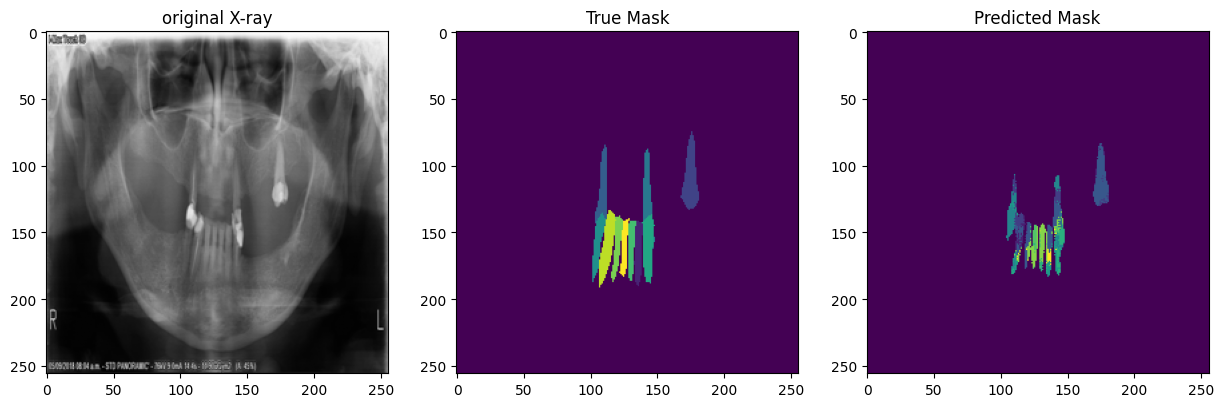

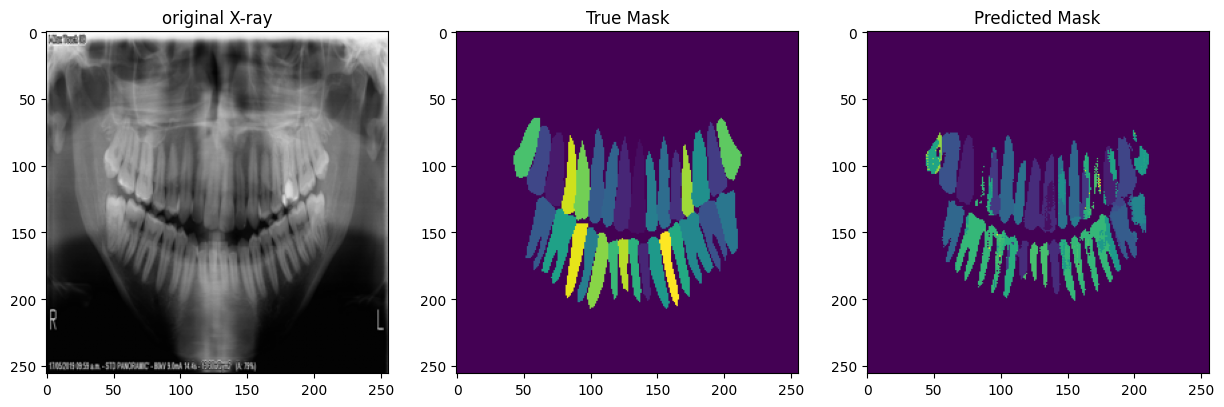

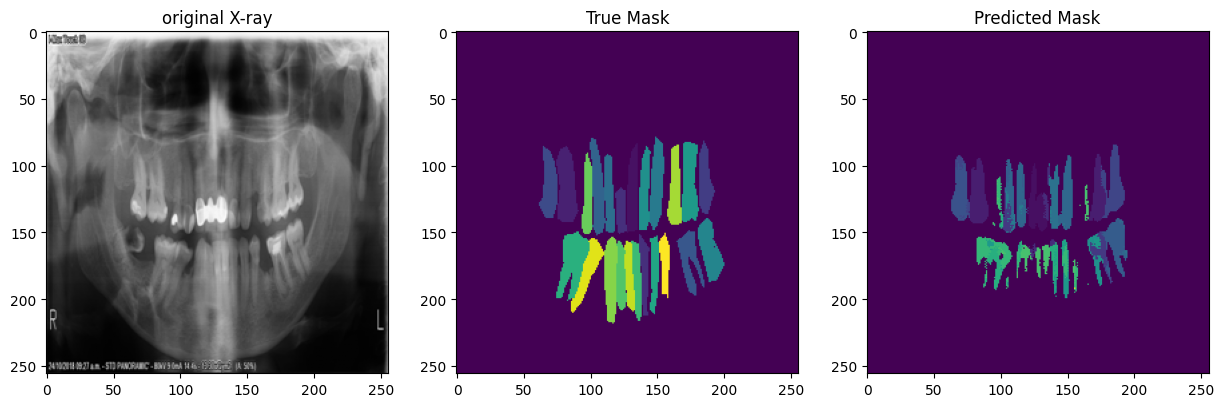

In [ ]:
print("\nVisualizing predictions on Validartion data")
display_prediction(unet_model, val_files, index = 2)
display_prediction(unet_model, val_files, index = 10)
display_prediction(unet_model, val_files, index = 21)

In [ ]:
def create_error_map(true_mask, pred_mask):
  # Generates an image showing where the prediction was correct TP vs incorrect (FP, FN)
  # Colors: White = TP (Correct), Red = FP (Overshoot), Blue = FN (Missed)

  # Create an empty RGB image
  H, W = true_mask.shape
  error_image = np.zeros((H, W, 3), dtype=np.uint8)
  # Identify Key Areas
  true_teeth = (true_mask != 0)
  pred_teeth = (pred_mask != 0)

  # Correctly identified tooth pixels (True Positive)
  tp = true_teeth & pred_teeth
  error_image[tp] = [255, 255, 255]

  # Predicted and Not True (False Positive)
  fp = pred_teeth & (~true_teeth)
  error_image[fp] = [255, 0, 0]

  # Not Prediction and True (False Negative)
  fn = (~pred_teeth) & true_teeth
  error_image[fn] = [0, 0, 255]
  return error_image

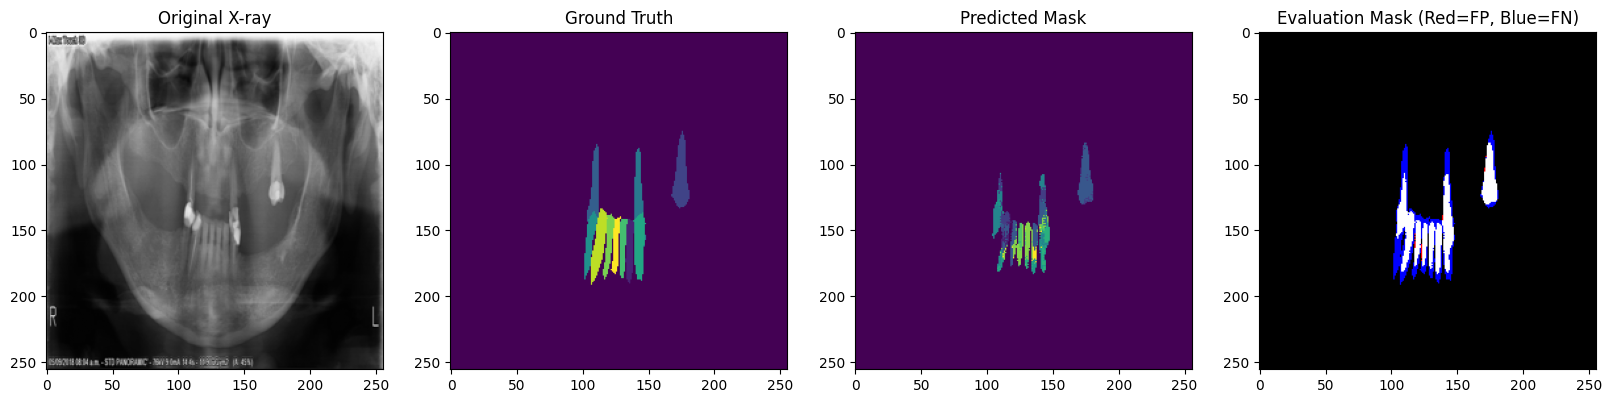

In [ ]:
# Generate the Error Map
error_mask = create_error_map(true_mask_2d, predicted_mask_2d)
original_xray_plot = np.array(Image.open(image_path).convert('L').resize((IMG_WIDTH, IMG_HEIGHT)))
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(original_xray_plot, cmap='gray')
plt.title('Original X-ray')

plt.subplot(1, 4, 2)
plt.imshow(true_mask_2d)
plt.title('Ground Truth')

plt.subplot(1, 4, 3)
plt.imshow(predicted_mask_2d)
plt.title('Predicted Mask')

plt.subplot(1, 4, 4)
plt.imshow(error_mask)
plt.title('Evaluation Mask (Red=FP, Blue=FN)')
plt.show()